In [1]:
import os
import numpy
from datetime import datetime, timedelta
import xarray
import random
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.transforms as mtransforms
import math
import matplotlib.pyplot as plt

In [2]:
WORK_SPACE = '/disk1/workspace/20240116'
MYD_LSR_AU_FOLDER = '/disk1/workspace/20240116/data/MYD_AU_45_2018_LSR'
AHI_LSR_AU_FOLDER = '/disk1/workspace/20240116/data/AHI_AU_45_2018_LSR'
ahi_ac_timelist_npy = os.path.join('/disk1/workspace/20240116/process', 'MYD_RAA_AU_30S_5-8_clear_ahi_time.npy')
# https://www-pm.larc.nasa.gov/cgi-bin/site/showdoc?mnemonic=SBAF
# LandCover=* ReferenceSRF=AHI TargetSRF=MISR Units=PseudoScaledRadiance Regression=Linear
# SR(AHI2MODIS) = SR(AHI)*Slope+Offset
AHI2MODIS_SBAF = {   # slope, offset
    '2_band3': [0.991, -0.0009574],      # Evergreen Broadleaf Forest
    '2_band4': [0.986, 0.0003388],
    '4_band3': [1.020, -0.001501],   # Deciduous Broadleaf Forest
    '4_band4': [0.990, 0.000488],
    '10_band3': [1.021, -0.000606],     # Grasslands
    '10_band4': [0.993, 0.0001707],
    '12_band3': [1.019, -0.001296],     # Croplands
    '12_band4': [0.989, 0.0005334],
}
year_first_day_date = datetime.strptime('2018-01-01T00:00:00Z', "%Y-%m-%dT%H:%M:%SZ")
# landcover Grasslands 10
# landcover EBF 2
# lc_idx = 10
lc_idx = 2

In [3]:
cloudmask_folder = '/disk4/AHI_CloudMask'

def is_clearsky_record_ex(matched_info_item):    
    lon = float(matched_info_item[0])
    lat = float(matched_info_item[1])
    ahi_time_str = matched_info_item[2]

    ahi_cm_dat = os.path.join(cloudmask_folder, ahi_time_str[:6], 'AHIcm.v0.'+ahi_time_str+'.dat')
    cloudmask = None
    cloudmask_res = 0.02
    if not os.path.exists(ahi_cm_dat):
        print('no file:', ahi_cm_dat)
        cloudmask = numpy.zeros((6000, 6000))
    else:
        try:
            cloudmask = numpy.fromfile(ahi_cm_dat, dtype=numpy.float32)
            cloudmask[cloudmask < 0.95] = 0.   # cloud
            cloudmask[cloudmask >= 0.95] = 1.
            cloudmask = cloudmask.reshape(6000, 6000)   # 0.02°
        except Exception as e:
            print(e)
            cloudmask = numpy.zeros((6000, 6000))

    cm_lon_idx = int((lon-85.)/cloudmask_res)
    cm_lat_idx = int((60.-lat)/cloudmask_res)
    cm_ex = 2
#     cm_ex = 7
    cm_roi_ex = cloudmask[cm_lat_idx-cm_ex:cm_lat_idx+cm_ex,cm_lon_idx-cm_ex:cm_lon_idx+cm_ex]
    is_clearsky = cm_roi_ex.min()
    
    return is_clearsky

In [4]:
def read_modis_roi(lon_ex, lat_ex, modis_tif_file, qa_tif_file=''):
    modis_ds = xarray.open_rasterio(modis_tif_file)[0]
    roi_ds = modis_ds.interp(x=lon_ex, y=lat_ex, method="nearest", kwargs={"fill_value": "extrapolate"}) # linear
    ref_dn = numpy.array(roi_ds.values)*1.
    ref_dn[ref_dn==-28672]=numpy.NaN
    ref_v = ref_dn*0.0001
    
    # QA
    if qa_tif_file != '':
        qa_ds = xarray.open_rasterio(qa_tif_file)[0]
        roi_qa_ds = qa_ds.interp(x=lon_ex, y=lat_ex, method="nearest", kwargs={"fill_value": "extrapolate"})
        qs_array = numpy.array(roi_qa_ds.values)*1.
        ref_qa = ref_v*0
        for j in range(len(ref_v)):
            for i in range(len(ref_v[0])):
                if qs_array[i][j] != 65535:
                    qs_v = bin(int(qs_array[i][j]))[2:].zfill(16)[::-1][0:3]
                    if qs_v == '000':
                        ref_qa[i][j]=1
        ref_qa[ref_qa==0]=numpy.NaN
        ref_v = ref_v*ref_qa
    
    return ref_v


def ahi_sr2modis_sr(ahi_sr_array, AHI2MODIS_para):
    slope = AHI2MODIS_para[0]
    offset = AHI2MODIS_para[1]
    offset_array = numpy.ones_like(ahi_sr_array)
    offset_array = offset_array * offset
    return ahi_sr_array * slope + offset_array

In [5]:
def identifer(data):
    down,up = numpy.nanpercentile(data,[0,75])
    IQR = up-down
    lower_limit = down - 1.5*IQR
    upper_limit = up + 1.5*IQR
    result = numpy.where(data > upper_limit,numpy.nan, data)
    result = numpy.where(result < lower_limit,numpy.nan, result)
    return result


def add_right_cax(ax, pad, width):

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(axpos.x1 + pad, axpos.y0, axpos.x1 + pad + width, axpos.y1)
    cax = ax.figure.add_axes(caxpos)

    return cax


def mapping_scatter(Y, X, figure_title='demo', band_name='band3', axis_min=0.0, axis_max=0.5, save_flag=0):
    # filter    
#     if band_name == 'band3':
#         axis_max = 0.3
    
    lim_x = numpy.copy(X)
    lim_y = numpy.copy(Y)

    up4_x = numpy.quantile(lim_x, 0.98, interpolation='higher')
    up4_y = numpy.quantile(lim_y, 0.98, interpolation='higher')
    lim_x[lim_x > up4_x] = numpy.nan
    lim_y[lim_y > up4_y] = numpy.nan

    lim_mask = (lim_x*lim_y)*0+1
    temp_x = lim_x*lim_mask
    temp_y = lim_y*lim_mask
    temp_x = temp_x[~numpy.isnan(temp_x)]
    temp_y = temp_y[~numpy.isnan(temp_y)]
    
    diff_array = abs(numpy.array(temp_y)-numpy.array(temp_x))/abs(numpy.minimum(numpy.array(temp_x), numpy.array(temp_y)))
    diff_array_filtered = numpy.array(identifer(diff_array))
    show_x = (diff_array_filtered*0+1)*temp_x
    show_y = (diff_array_filtered*0+1)*temp_y
    
    X = show_x[~numpy.isnan(show_x)]
    Y = show_y[~numpy.isnan(show_y)]

    fig = plt.figure(figsize=(4, 4))
    ax1 = fig.add_subplot(111, aspect='equal',facecolor='whitesmoke', alpha=0.1)
    ax1.grid(linestyle='--', linewidth=0.3)

    model = LinearRegression()
    x = X.reshape(-1, 1)
    model.fit(x, Y)
    y_pred = model.predict(x)
    xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
    k = model.coef_[0]
    b = model.intercept_
    yy = k * xx + b

    # rmse = math.sqrt(mean_squared_error(X, Y))
    rmse = math.sqrt(mean_squared_error(Y, y_pred))
    bias = numpy.mean(y_pred - Y)
    print('bias:', bias)

    N = len(X)
    x = numpy.arange(axis_min, axis_max + 1)
    y = 1 * x

#     g_x, g_y = numpy.mgrid[axis_min:axis_max:500j, axis_min:axis_max:500j]
#     positions = numpy.vstack([g_x.ravel(), g_y.ravel()])
#     values = numpy.vstack([X, Y])
#     kernel = gaussian_kde(values)
#     Z = numpy.reshape(kernel(positions).T, g_x.shape)
    
    # Calculate the point density
    xy = numpy.vstack([X, Y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    X, Y, z = X[idx], Y[idx], z[idx]
    z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
    im = ax1.scatter(X, Y, marker='o', c=z, s=8, cmap='turbo')

    ax1.minorticks_on()
    # x_major_locator = plt.MultipleLocator(5)
    x_minor_locator = plt.MultipleLocator(0.05)
    ax1.xaxis.set_minor_locator(x_minor_locator)
    # ax.xaxis.set_major_locator(x_major_locator)
    ax1.yaxis.set_minor_locator(x_minor_locator)
    # ax.yaxis.set_major_locator(x_major_locator)

    ax1.tick_params(axis="y", which='minor', length=3, direction='in', labelsize=15)
    ax1.tick_params(axis="y", which='major', length=5, direction='in', labelsize=15)

    ax1.tick_params(axis="x", which='minor', length=3, direction='in', labelsize=15)
    ax1.tick_params(axis="x", which='major', length=5, direction='in', labelsize=15)

    # ax1.spines['right'].set_color('none')
    # ax1.spines['top'].set_color('none')
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['bottom'].set_linewidth(1)

    ax1.set_xticks(numpy.arange(axis_min, axis_max + 0.1, 0.1))
    ax1.set_yticks(numpy.arange(axis_min + 0.1, axis_max + 0.1, 0.1))

    band_label = {
        'band3': 'Band3',
        'band4': 'Band4',
    }

    ax1.set_ylabel("AHI LSR", fontsize=15)
    ax1.set_xlabel("MODIS LSR", fontsize=15)

#     ax1.imshow(numpy.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[axis_min, axis_max, axis_min, axis_max], alpha=0.8, zorder=0)
#     ax1.plot(X, Y, 'k.', markersize=0.5, alpha=0.8, zorder=4)
    ax1.plot(x, y, color='k', linewidth=1, linestyle='-', zorder=1)
    ax1.plot(xx, yy, color='r', linewidth=1, linestyle='-.', zorder=2)

    r_, p = pearsonr(X, Y)
    p_str = '%.3e' % p
    
    label_str = label_str = 'y = {}x + {}\nRMSE = {}\nr = {}\n'.format(round(k, 2), round(b, 2), round(rmse, 3), round(r_, 2))
    if b < 0:
        label_str = label_str = 'y = {}x - {}\nRMSE = {}\nr = {}\n'.format(round(k, 2), abs(round(b, 2)), round(rmse, 3), round(r_, 2))

    text_x = axis_min + (axis_max - axis_min) * 0.07
    text_y = axis_max - (axis_max - axis_min) * 0.35
    ax1.text(text_x, text_y, s=label_str, fontsize=18)
    
    band_label = band_label[band_name]
    text_x2 = axis_min + (axis_max - axis_min) * 0.7
    text_y2 = axis_min + (axis_max - axis_min) * 0.1
    if band_name == 'band3':
        ax1.text(text_x2, text_y2, color='red', s=band_label, fontsize=18)
    else:
        ax1.text(text_x2, text_y2, color='firebrick', s=band_label, fontsize=18)

    cax = add_right_cax(ax1, pad=0.01, width=0.03)
    cb = fig.colorbar(im, cax=cax)
    
    ax1.set_xlim(axis_min, axis_max)
    ax1.set_ylim(axis_min, axis_max)
    
    if save_flag:
        mapping_folder = os.path.join(WORK_SPACE, 'display')
        figure_folder = os.path.join(mapping_folder, str(PIXEL_PAIRS_MAX))
        if not os.path.exists(figure_folder):
            os.makedirs(figure_folder)
        fig_filename = os.path.join(figure_folder, figure_title + '.png')
        fig.savefig(fig_filename, dpi=1000, bbox_inches='tight')
        print(fig_filename)
        plt.close(fig)
        plt.clf()
    # plt.show()
    
    # slope r RMSE
    return k, r_, rmse

In [6]:
ahi_ac_timelist = numpy.load(ahi_ac_timelist_npy)

In [7]:
modis_lsr_list_b3 = []
ahi_lsr_list_b3 = []
modis_lsr_list_b4 = []
ahi_lsr_list_b4 = []
for ahi_info_item in ahi_ac_timelist:
    roi_lon = float(ahi_info_item[0])
    roi_lat = float(ahi_info_item[1])
    ahi_time = ahi_info_item[2]
    roi_lc_idx = ahi_info_item[3]
    if roi_lc_idx == str(lc_idx):
        modis_day = ahi_time[:8]
        current_time = datetime.strptime(modis_day + 'T23:59:59Z', "%Y%m%dT%H:%M:%SZ")
        modis_doy = (current_time-year_first_day_date).days + 1
        modis_doy_str = (3-len(str(modis_doy)))*'0'+str(modis_doy)

        modis_geotiff_b3 = os.path.join(MYD_LSR_AU_FOLDER, 'MYD09GA.061_sur_refl_b01_1_doy2018'+modis_doy_str+'_aid0001.tif')
        modis_geotiff_b4 = os.path.join(MYD_LSR_AU_FOLDER, 'MYD09GA.061_sur_refl_b02_1_doy2018'+modis_doy_str+'_aid0001.tif')

        ahi_npy_b3 = os.path.join(AHI_LSR_AU_FOLDER, ahi_info_item[0]+'_'+ahi_info_item[1]+'_'+ahi_time+'_ac_band3.npy')
        ahi_npy_b4 = os.path.join(AHI_LSR_AU_FOLDER, ahi_info_item[0]+'_'+ahi_info_item[1]+'_'+ahi_time+'_ac_band4.npy')

        if os.path.exists(ahi_npy_b3) and os.path.exists(ahi_npy_b4):
            if is_clearsky_record_ex(ahi_info_item):
#             if True:
                # band3
                roi_ahi_info_b3 = numpy.load(ahi_npy_b3, allow_pickle=True)[0]
                roi_ahi_lsr_b3 = roi_ahi_info_b3['roi_ahi_sr']
                roi_ahi_lons_b3 = roi_ahi_info_b3['roi_lons']
                roi_ahi_lats_b3 = roi_ahi_info_b3['roi_lats']

                qs_geotiff_b3 = modis_geotiff_b3.replace('sur_refl_b01','state_1km')
                roi_modis_lsr_b3 = read_modis_roi(roi_ahi_lons_b3, roi_ahi_lats_b3, modis_geotiff_b3, qs_geotiff_b3)
#                 roi_modis_lsr_b3 = read_modis_roi(roi_ahi_lons_b3, roi_ahi_lats_b3, modis_geotiff_b3)
                roi_ahi2modis_lsr_b3=ahi_sr2modis_sr(roi_ahi_lsr_b3, AHI2MODIS_SBAF[str(lc_idx)+'_band3'])

                modis_sr_1d_b3 = roi_modis_lsr_b3.flatten()
                ahi_sr_1d_b3 = roi_ahi2modis_lsr_b3.flatten()

                nan_indices_b3 = numpy.isnan(modis_sr_1d_b3) | numpy.isnan(ahi_sr_1d_b3)
                modis_sr_1d_b3 = modis_sr_1d_b3[~nan_indices_b3]
                ahi_sr_1d_b3 = ahi_sr_1d_b3[~nan_indices_b3]

                modis_lsr_list_b3.extend(modis_sr_1d_b3)
                ahi_lsr_list_b3.extend(ahi_sr_1d_b3)
                # band4
                roi_ahi_info_b4 = numpy.load(ahi_npy_b4, allow_pickle=True)[0]
                roi_ahi_lsr_b4 = roi_ahi_info_b4['roi_ahi_sr']
                roi_ahi_lons_b4 = roi_ahi_info_b4['roi_lons']
                roi_ahi_lats_b4 = roi_ahi_info_b4['roi_lats']

                qs_geotiff_b4 = modis_geotiff_b4.replace('sur_refl_b02','state_1km')
                roi_modis_lsr_b4 = read_modis_roi(roi_ahi_lons_b4, roi_ahi_lats_b4, modis_geotiff_b4, qs_geotiff_b4)
#                 roi_modis_lsr_b4 = read_modis_roi(roi_ahi_lons_b4, roi_ahi_lats_b4, modis_geotiff_b4)
                roi_ahi2modis_lsr_b4=ahi_sr2modis_sr(roi_ahi_lsr_b4, AHI2MODIS_SBAF[str(lc_idx)+'_band4'])

                modis_sr_1d_b4 = roi_modis_lsr_b4.flatten()
                ahi_sr_1d_b4 = roi_ahi2modis_lsr_b4.flatten()

                nan_indices_b4 = numpy.isnan(modis_sr_1d_b4) | numpy.isnan(ahi_sr_1d_b4)
                modis_sr_1d_b4 = modis_sr_1d_b4[~nan_indices_b4]
                ahi_sr_1d_b4 = ahi_sr_1d_b4[~nan_indices_b4]

                modis_lsr_list_b4.extend(modis_sr_1d_b4)
                ahi_lsr_list_b4.extend(ahi_sr_1d_b4)

In [8]:
PIXEL_PAIRS_MAX = 1000
print(len(ahi_lsr_list_b3))
if len(ahi_lsr_list_b3) > PIXEL_PAIRS_MAX:
    # random pairs mapping
    index_array = random.sample([idx for idx in range(len(ahi_lsr_list_b3))], PIXEL_PAIRS_MAX)
    index_array = numpy.sort(index_array).tolist()

    modis_lsr_pts_b3 = numpy.array(modis_lsr_list_b3)
    show_modis_sr_b3 = modis_lsr_pts_b3[index_array]
    ahi_lsr_pts_b3 = numpy.array(ahi_lsr_list_b3)
    show_ahi_sr_b3 = ahi_lsr_pts_b3[index_array]
    
    modis_lsr_pts_b4 = numpy.array(modis_lsr_list_b4)
    show_modis_sr_b4 = modis_lsr_pts_b4[index_array]
    ahi_lsr_pts_b4 = numpy.array(ahi_lsr_list_b4)
    show_ahi_sr_b4 = ahi_lsr_pts_b4[index_array]
else:
    print(len(ahi_lsr_list_b3))
    show_modis_sr_b3 = numpy.array(modis_lsr_list_b3)
    show_ahi_sr_b3 = numpy.array(ahi_lsr_list_b3)
    show_modis_sr_b4 = numpy.array(modis_lsr_list_b4)
    show_ahi_sr_b4 = numpy.array(ahi_lsr_list_b4)

1359


bias: -1.283290664731093e-17


(0.7294776392067884, 0.8665399956355555, 0.01647352068614561)

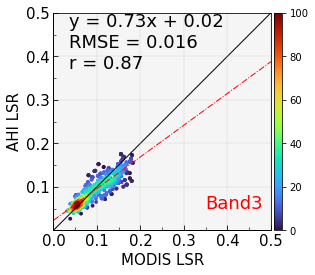

In [9]:
figure_title = 'MYD_AU_b3_'+str(lc_idx)
mapping_scatter(show_ahi_sr_b3, show_modis_sr_b3, figure_title, 'band3', axis_min=0.0, axis_max=0.5,save_flag=0)

bias: 2.6433881538694202e-17


(0.8096716347991724, 0.8204714360695321, 0.02444305089313968)

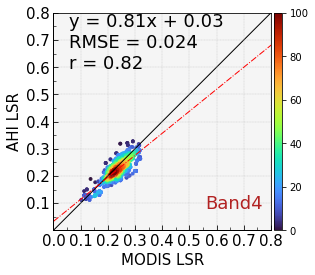

In [10]:
figure_title = 'MYD_AU_b4_'+str(lc_idx)
mapping_scatter(show_ahi_sr_b4, show_modis_sr_b4, figure_title, 'band4', axis_min=0.0, axis_max=0.8,save_flag=0)